In [14]:
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
from tqdm import tqdm, trange

In [5]:
text = ''

In [6]:
chars = list(set(text))
data_size, vocab_size = len(text), len(chars)
char_to_ix = { ch:i for i,ch in enumerate(chars) }
ix_to_char = { i:ch for i,ch in enumerate(chars) }

In [7]:
def convert(data):
    x = np.zeros((len(data), vocab_size), dtype='float32')
    for k, s in enumerate(data):
        x[k, char_to_ix[s]] = 1
    return x

def generate(batch_size, data, length):
    idx = np.arange(len(data) - length - 1)
    np.random.shuffle(idx)
    for j in range(0, len(idx), batch_size):
        x, y = [], []
        for i, index in enumerate(idx[j:j+batch_size]):
            x.append(convert(data[index:index+length]))
            y.append(char_to_ix[data[index+length]])
        yield np.array(x, dtype='float32'), np.array(y, dtype='int32')

In [8]:
import torch
from torch import nn
from torch.autograd import Variable

class UnaryLSTM(nn.Module):
    def __init__(self, input_size, hidden_size):
        super().__init__()
        
        self.cell = nn.LSTMCell(input_size, hidden_size)
        self.hidden_size = hidden_size
 
    def forward(self, x):
        """
        x.size() == (batch_size, seq_len, feature)
        """
        params = (Variable(torch.zeros(x.size(0), self.hidden_size)).cuda(),
                  Variable(torch.zeros(x.size(0), self.hidden_size)).cuda())
        
        for t in range(x.size(1)):
            params = self.cell(x[:, t], params)
        return params[0]
    
class CharRNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers=2):
        super().__init__()
        
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers-1, batch_first=True)
        self.last = nn.Sequential(
#             it just doesn't call .cuda by itself, dunno why
            UnaryLSTM(hidden_size, hidden_size), #.cuda(),
            nn.Linear(hidden_size, input_size),
        )
        self.hidden_size = hidden_size
        self.num_layers = num_layers - 1
        
    def forward(self, x):
        params = (Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size)).cuda(),
                  Variable(torch.zeros(self.num_layers, x.size(0), self.hidden_size)).cuda())
    
        x, params = self.lstm(x, params)
        x = self.last(x)
        return x

In [9]:
rnn = CharRNN(len(chars), 100).cuda()
criterion = torch.nn.CrossEntropyLoss()
losses = []

In [10]:
optimizer = torch.optim.Adam(rnn.parameters(), lr=1e-3)

In [12]:
epochs = 50
batch_size = 40
freq = 5

In [48]:
bar = trange(epochs, leave=False)
for epoch in bar:
    mean_loss = 0
    step = 0
    for x, y in generate(batch_size, text, 30):
        x = Variable(torch.from_numpy(x)).cuda()
        y = Variable(torch.from_numpy(y.astype(np.long)), requires_grad=False).cuda()
        
        y_pred = rnn(x)
        loss = criterion(y_pred, y)
        mean_loss += loss.cpu().data[0]
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        step += 1
        if step >= freq:
            losses.append(mean_loss / step)
            bar.set_description(str(losses[-1]))
            mean_loss = step = 0
    if step:
        losses.append(mean_loss / step)
        bar.set_description(str(losses[-1]))

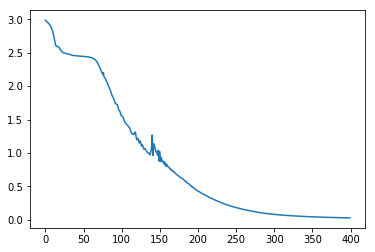

In [49]:
plt.plot(losses)

In [50]:
x = 'some string '

In [ ]:
for _ in range(10):
    t = np.array([convert(x)])
    t = Variable(torch.from_numpy(t)).cuda()
    prob = rnn(t).cpu().data.numpy()[0]
    prob = np.exp(prob)
    x += np.random.choice(chars, p = prob / sum(prob))
x